In [1]:
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 552 kB/s eta 0:00:01


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

In [3]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [4]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
4586522,QUEENSBERRY,CHETWYND STREET,VICTORIA STREET,ROSSLYN STREET,5,6061W,10/02/2012 05:45:02 PM,10/02/2012 06:14:41 PM,1779,1/2P RPA M-F 7:30-18:30,0,192,2627
4846257,QUEENSBERRY,WILLIAM STREET,VICTORIA STREET,WALSH STREET,1,C5580,18/02/2012 04:07:06 PM,18/02/2012 04:13:25 PM,379,4P MTR M-SAT 7:30-18:30,0,1428,4191
11389488,PRINCES THEATRE,EXHIBITION STREET,LONSDALE STREET,LT BOURKE STREET,1,C496,05/09/2012 05:47:52 PM,05/09/2012 07:30:00 PM,6128,1P MTR M-SAT 7:30-19:30,1,647,4923
3585709,PRINCES THEATRE,LONSDALE STREET,RUSSELL STREET,EXHIBITION STREET,3,2846N,12/01/2012 12:02:20 PM,12/01/2012 12:03:45 PM,85,1P MTR M-F 7:30-16:00,0,894,1838
6140082,HARDWARE,LONSDALE STREET,QUEEN STREET,ELIZABETH STREET,1,C2944,28/03/2012 03:08:52 PM,28/03/2012 03:59:20 PM,3028,1P MTR M-SAT 7:30-19:30,0,894,2024


In [5]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [6]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [7]:
#Target field identification
duration = parkingdata['Duration of Parking Event (in seconds)'].copy()

print('Minimum parking duration (seconds): ' + str(duration.min()))
print('Maximum parking duration (seconds): ' + str(duration.max()))
print('\nMinimum parking duration (hour): ' + str(duration.min()/3600))
print('Maximum parking duration (hour): ' + str(duration.max()/3600))
print('\nMinimum parking duration is under [' + str(math.trunc(duration.min()/3600) + 1) + '] hours')
print('Maximum parking duration is under [' + str(math.trunc(duration.max()/3600) + 1) + '] hours')

durList = []
static = 1
df = pd.DataFrame()

for record in duration.values:
    hour = 3600
    index = 0
    while static == 1:
        if record < hour:
#             print("\nDuration in seconds: " + str(record))
            data = math.trunc(record/3600) + 1
            durList.append(data)
#             print("Duration is under " + str(data) + " hours")
            break
        else:
            hour += 3600

df.insert(0, 'Duration (Hours)', durList, True)
target = df['Duration (Hours)']
target.head(10)

Minimum parking duration (seconds): 61
Maximum parking duration (seconds): 86264

Minimum parking duration (hour): 0.016944444444444446
Maximum parking duration (hour): 23.962222222222223

Minimum parking duration is under [1] hours
Maximum parking duration is under [24] hours


0    1
1    1
2    2
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Duration (Hours), dtype: int64

In [8]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Street ID,Device ID,Arrival Hour,Departure Hour
4586522,0,0,0,0,0,0,5,192,2627,17,18
4846257,0,1,0,1,1,0,1,1428,4191,16,16
11389488,1,2,1,2,2,1,1,647,4923,17,19
3585709,1,3,2,3,3,0,3,894,1838,12,12
6140082,2,3,3,4,2,0,1,894,2024,15,15
2066473,3,4,4,5,4,0,2,839,806,8,8
4645104,4,5,5,6,5,0,4,856,2107,10,11
3227933,5,3,6,7,6,0,4,894,1859,16,16
1060124,6,6,7,8,4,0,3,728,4459,13,13
5791356,2,3,3,4,2,0,1,894,4941,18,18


In [9]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [10]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [11]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   24.5s finished


In [12]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 14,
 'splitter': 'best'}

In [13]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  entropy
Best max_depth:  15
Best min_samples_leaf:  4
Best min_samples_split:  14
Best splitter:  best


In [14]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.8379
556,entropy,15.0,10.0,14.0,best,0.8521
557,entropy,15.0,10.0,14.0,random,0.8444
558,entropy,15.0,10.0,16.0,best,0.8522


In [15]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [16]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.7905
Score with 2 selected features: 0.7905
Score with 3 selected features: 0.83

Indexs of the desired features
[2, 0, 5]


In [17]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Area Name,In Violation?
4586522,0,0,0
4846257,0,0,0
11389488,1,1,1
3585709,2,1,0
6140082,3,2,0
2066473,4,3,0
4645104,5,4,0
3227933,6,5,0
1060124,7,6,0
5791356,3,2,0


In [18]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:    9.1s finished


In [19]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'splitter': 'best'}

In [20]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  gini
Best max_depth:  None
Best min_samples_leaf:  4
Best min_samples_split:  16
Best splitter:  best


In [21]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.8254
556,entropy,15.0,10.0,14.0,best,0.8277
557,entropy,15.0,10.0,14.0,random,0.8271
558,entropy,15.0,10.0,16.0,best,0.8277


In [22]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

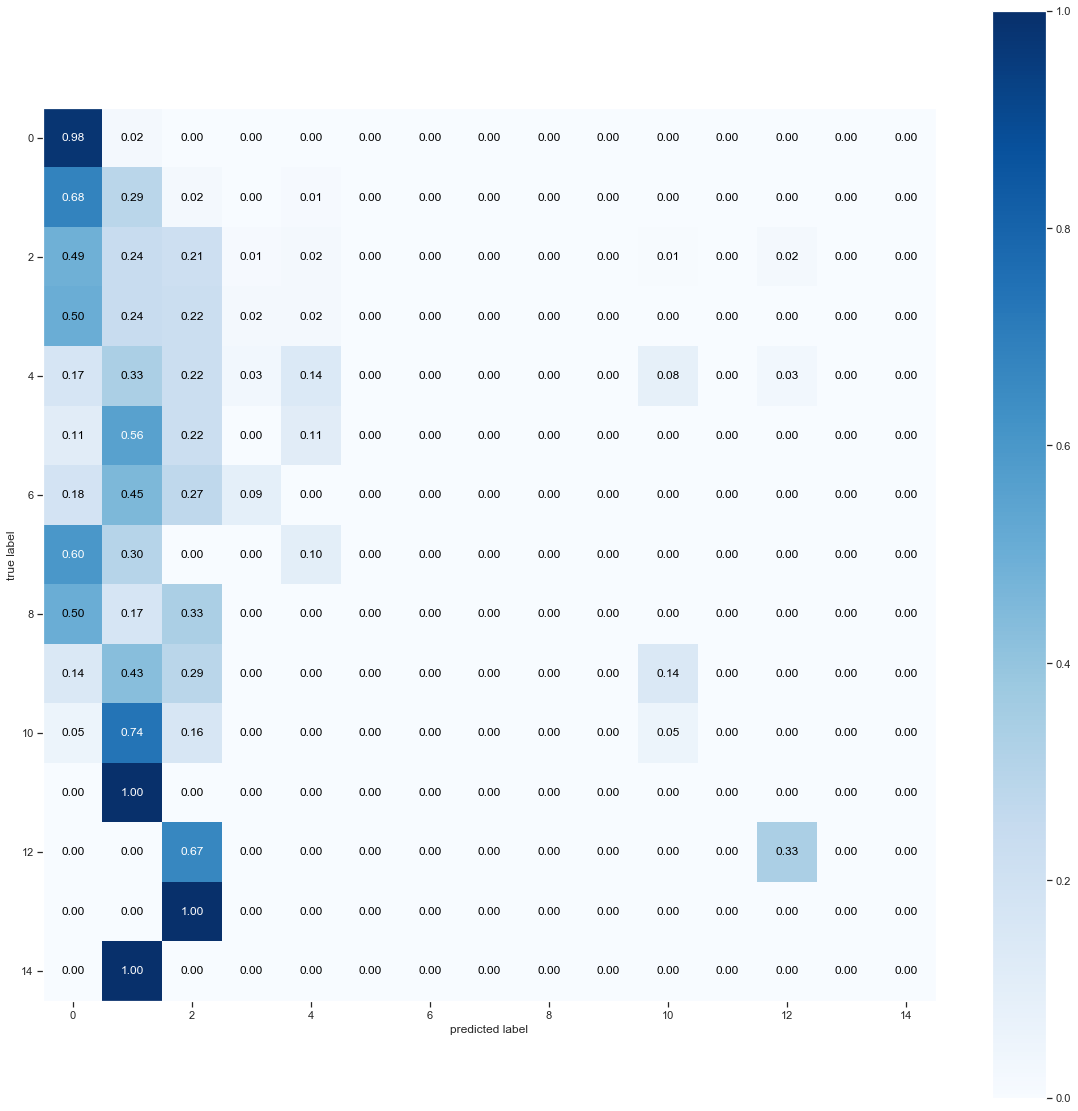

In [23]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                               figsize=(20, 20))
plt.show()

In [27]:
print ("Accuracy: {:.5f}".format(dtc.score(x_test, y_test)))

Accuracy: 0.82360


In [25]:
print (classification_report(y_test, predicted))

              precision    recall  f1-score   support

           1       0.86      0.98      0.92      3952
           2       0.53      0.29      0.37       697
           3       0.39      0.21      0.27       189
           4       0.12      0.02      0.03        50
           5       0.24      0.14      0.18        36
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         7
          11       0.12      0.05      0.07        19
          12       0.00      0.00      0.00         8
          13       0.17      0.33      0.22         3
          16       0.00      0.00      0.00         2
          24       0.00      0.00      0.00         1

    accuracy                           0.82      5000
   macro avg       0.16      0.13      0.14      5000
weighted avg       0.78   

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#visualise the tree
from sklearn import tree
with open('durationTarget.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    
